# Quiz Question Difficulty Analysis

## Research Question
**What words or phrases appear more frequently in questions that students tend to do poorly on, and what appear more frequently in questions that students do well on?**

## Methodology
We compare the vocabulary of questions where students performed poorly (<40% correct) versus well (>60% correct).

1.  **Feature Extraction:** We analyze single words (unigrams) and two-word phrases (bigrams), removing common stopwords.
2.  **Statistical Analysis:** We measure the association of each term with difficulty using the **Log-Odds Ratio** with **Haldane-Anscombe correction** (smoothing with 0.5).
3.  **Significance Testing:** To identify statistically significant terms, we use **Fisher's Exact Test** for rare terms (expected frequency < 5) and the **Chi-Square Test** for common terms, applying the **Benjamini-Hochberg correction** to control the False Discovery Rate (FDR < 0.05).

In [1]:
import json
import pandas as pd
import numpy as np
import re
import os
from collections import Counter
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

DATA_PATH = 'quiz_questions.json'
MIN_COUNT = 20
POOR_THRESHOLD = 0.4
GOOD_THRESHOLD = 0.6

for resource in ['punkt', 'stopwords', 'punkt_tab']:
    try:
        nltk.data.find(f'tokenizers/{resource}')
    except LookupError:
        nltk.download(resource, quiet=True)

Loaded 10191 questions.


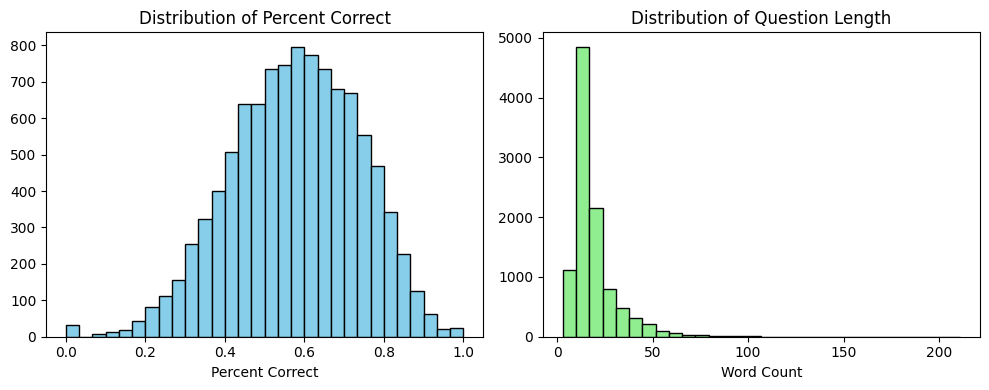

In [2]:
def load_and_preprocess(path):
    try:
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        df = pd.DataFrame(data)
        print(f"Loaded {len(df)} questions.")
        return df
    except FileNotFoundError:
        print(f"Error: File {path} not found.")
        return pd.DataFrame()

df = load_and_preprocess(DATA_PATH)

if not df.empty:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(df['percent_correct'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution of Percent Correct')
    plt.xlabel('Percent Correct')

    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    plt.subplot(1, 2, 2)
    plt.hist(df['word_count'], bins=30, color='lightgreen', edgecolor='black')
    plt.title('Distribution of Question Length')
    plt.xlabel('Word Count')
    plt.tight_layout()
    plt.show()

In [3]:
stop_words = set(stopwords.words('english'))
keep_words = {'what', 'which', 'how', 'why', 'when', 'where', 'who', 'not', 'no'}
stop_words = stop_words - keep_words
CLEANING_PATTERN = re.compile(r'[^\w\s\']')

def get_tokens(text, n_gram_type='unigram'):
    text = text.lower()
    text = CLEANING_PATTERN.sub(' ', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    
    if n_gram_type == 'bigram':
        return [' '.join(tokens[i:i+2]) for i in range(len(tokens)-1)]
    return tokens

df['unigrams'] = df['text'].apply(lambda x: get_tokens(x, 'unigram'))
df['bigrams'] = df['text'].apply(lambda x: get_tokens(x, 'bigram'))

In [4]:
def analyze_features(df, feature_col, poor_thresh, good_thresh, min_count):
    poor_df = df[df['percent_correct'] < poor_thresh]
    good_df = df[df['percent_correct'] > good_thresh]
    
    print(f"Poor questions: {len(poor_df)} ({len(poor_df)/len(df)*100:.1f}%)")
    print(f"Good questions: {len(good_df)} ({len(good_df)/len(df)*100:.1f}%)")
    if len(poor_df) < 30 or len(good_df) < 30:
        print("WARNING: Sample size too small for reliable analysis")
    
    poor_docs_features = [set(tokens) for tokens in poor_df[feature_col]]
    good_docs_features = [set(tokens) for tokens in good_df[feature_col]]
    
    poor_counts = Counter()
    for doc_features in poor_docs_features:
        poor_counts.update(doc_features)
        
    good_counts = Counter()
    for doc_features in good_docs_features:
        good_counts.update(doc_features)
    
    total_poor_docs = len(poor_df)
    total_good_docs = len(good_df)
    
    all_features = set(list(poor_counts.keys()) + list(good_counts.keys()))
    features_to_analyze = {f for f in all_features if (poor_counts[f] + good_counts[f]) >= min_count}
    
    results = []
    for feature in features_to_analyze:
        p_count = poor_counts.get(feature, 0)
        g_count = good_counts.get(feature, 0)
        
        p_prob = (p_count + 0.5) / (total_poor_docs + 1)
        g_prob = (g_count + 0.5) / (total_good_docs + 1)
        
        log_odds = np.log2(p_prob / g_prob)
        
        # Contingency table: [[docs_with_feature_in_poor, docs_without_feature_in_poor], 
        #                     [docs_with_feature_in_good, docs_without_feature_in_good]]
        contingency = [[p_count, total_poor_docs - p_count], 
                       [g_count, total_good_docs - g_count]]
        
        # Check expected frequencies for Chi-square
        row_sums = [sum(r) for r in contingency]
        col_sums = [sum(c) for c in zip(*contingency)]
        total = sum(row_sums)
        expected = (row_sums[0] * col_sums[0]) / total
        
        if expected < 5:
            _, p_val = fisher_exact(contingency)
        else:
            _, p_val, _, _ = chi2_contingency(contingency)
            
        results.append({
            'feature': feature,
            'log_odds': log_odds,
            'p_value': p_val,
            'poor_count': p_count,
            'good_count': g_count
        })
        
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        _, pvals_adj, _, _ = multipletests(results_df['p_value'], alpha=0.05, method='fdr_bh')
        results_df['p_value_adj'] = pvals_adj
        results_df['significant'] = results_df['p_value_adj'] < 0.05
    
    return results_df

Poor questions: 1444 (14.2%)
Good questions: 4676 (45.9%)
Poor questions: 1444 (14.2%)
Good questions: 4676 (45.9%)


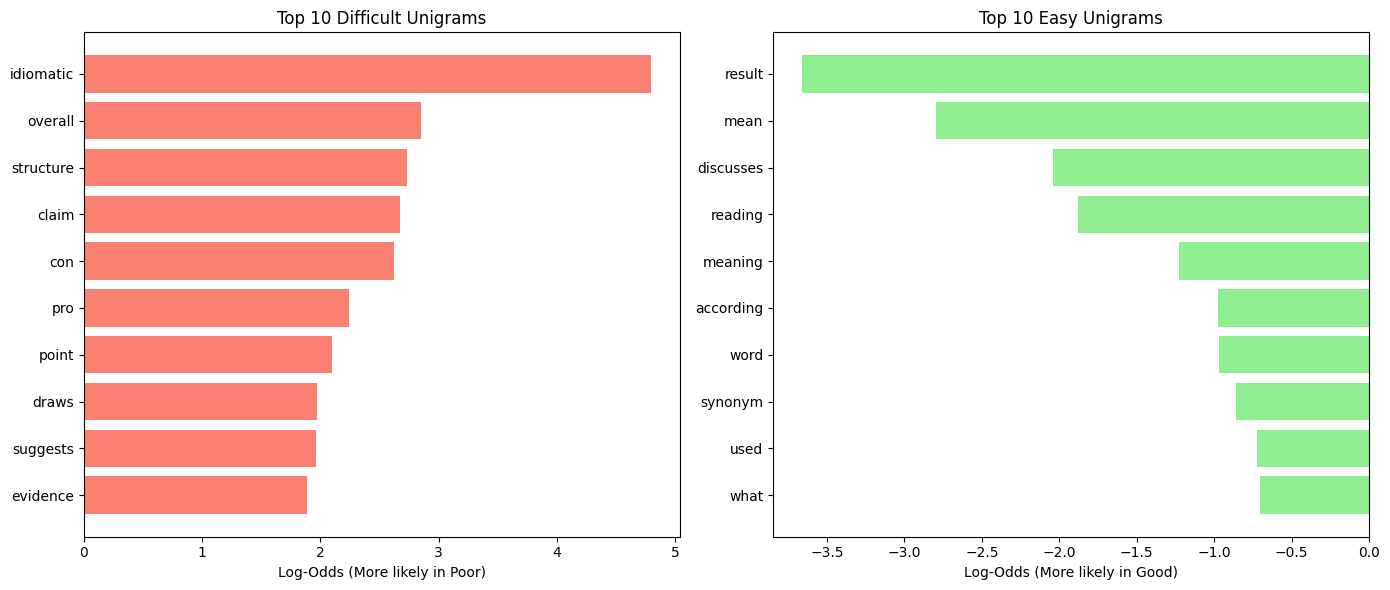

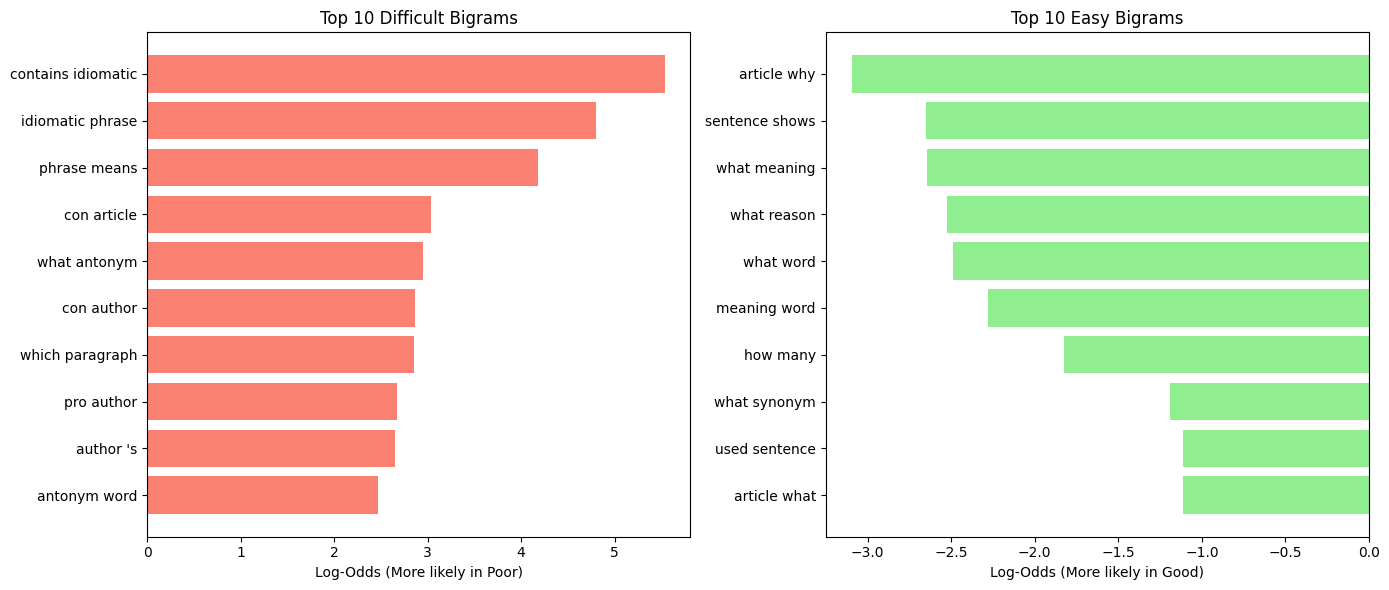

In [5]:
uni_results = analyze_features(df, 'unigrams', POOR_THRESHOLD, GOOD_THRESHOLD, MIN_COUNT)

bi_results = analyze_features(df, 'bigrams', POOR_THRESHOLD, GOOD_THRESHOLD, MIN_COUNT)

def plot_top_features(results_df, title, top_n=10):
    sig = results_df[results_df['significant']]
    difficult = sig[sig['log_odds'] > 0].nlargest(top_n, 'log_odds')
    easy = sig[sig['log_odds'] < 0].nsmallest(top_n, 'log_odds')
    
    if difficult.empty and easy.empty:
        print(f"No significant features found for {title}")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    if not difficult.empty:
        ax1.barh(difficult['feature'], difficult['log_odds'], color='salmon')
        ax1.set_title(f'Top {top_n} Difficult {title}')
        ax1.set_xlabel('Log-Odds (More likely in Poor)')
        ax1.invert_yaxis()
        
    if not easy.empty:
        ax2.barh(easy['feature'], easy['log_odds'], color='lightgreen')
        ax2.set_title(f'Top {top_n} Easy {title}')
        ax2.set_xlabel('Log-Odds (More likely in Good)')
        ax2.invert_yaxis()
        
    plt.tight_layout()
    
    if not os.path.exists('outputs'):
        os.makedirs('outputs')
    
    filename = f"outputs/top_features_{title.lower()}.png"
    plt.savefig(filename)
    
    plt.show()

plot_top_features(uni_results, "Unigrams")
plot_top_features(bi_results, "Bigrams")

In [6]:
def print_full_lists(results_df, title):
    if results_df.empty or 'significant' not in results_df.columns:
        print(f"No results for {title}")
        return
        
    sig = results_df[results_df['significant']]
    
    difficult = sig[sig['log_odds'] > 0].sort_values('log_odds', ascending=False)['feature'].tolist()
    
    easy = sig[sig['log_odds'] < 0].sort_values('log_odds', ascending=True)['feature'].tolist()
    
    print(f"\n{title.upper()}")
    print(f"\nSIGNIFICANTLY DIFFICULT {title.upper()}")
    print(", ".join(difficult))
        
    print(f"\nSIGNIFICANTLY EASY {title.upper()}")
    print(", ".join(easy))

print_full_lists(uni_results, "Unigrams")
print_full_lists(bi_results, "Bigrams")


UNIGRAMS

SIGNIFICANTLY DIFFICULT UNIGRAMS
idiomatic, overall, structure, claim, con, pro, point, draws, suggests, evidence, argument, included, paragraphs, support, something, phrase, back, provides, text, explains, paragraph, author, best, two, could, reasons, central, supports, connection, would, information, select, idea, not, section, least, describes, shows, except, article, which

SIGNIFICANTLY EASY UNIGRAMS
result, mean, discusses, reading, meaning, according, word, synonym, used, what

BIGRAMS

SIGNIFICANTLY DIFFICULT BIGRAMS
contains idiomatic, idiomatic phrase, phrase means, con article, what antonym, con author, which paragraph, pro author, author 's, antonym word, article contains, two sentences, draws connection, paragraph article, article draws, shows reason, provides evidence, article least, paragraph best, article provides, paragraph shows, connection following, what best, article best, support central, best describes, supports central, best shows, article explains, n